In [12]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

DATASET_DIRECTORY = r"C:\Users\user\Desktop\Face-Mask-Detection-Using-Hardware\dataset"
TYPES = ["with_mask", "without_mask"]

# All the Images Array will be appended in data list, whereas, the label of images(with_mask or without_mask) will be appended in labels
data = []
labels = []

print("Loading Images present our dataset!")

for dir_type in TYPES:
    path = os.path.join(DATASET_DIRECTORY,dir_type)
    print(path);
    #listdir(path) function will list down all the diretories in the path specified
    for img in os.listdir(path):
        image_path = os.path.join(path,img)
        image = load_img(image_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(dir_type)

# We've got the data as numerical values, however, the labels are still alphabetical values
# Thus we will convert them into categorical variables using LabelBinarizer from sklearn library

#This is performing ONE-HOT ENCODING on labels
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype = "float32")
labels = np.array(labels)

print("Data Preprocessing Completed!")

Loading Images present our dataset!
C:\Users\user\Desktop\Face-Mask-Detection-Using-Hardware\dataset\with_mask


C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


C:\Users\user\Desktop\Face-Mask-Detection-Using-Hardware\dataset\without_mask
Data Preprocessing Completed!


In [13]:
#Splitting data into Training and Testing Data

from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.15, stratify = labels, random_state = 42)

print("Data Split into Training and Testing Data!")

Data Split into Training and Testing Data!


In [14]:
#Data Augmentation: Constructing the Training Image Generator
#This kind of increases the dataset number, it creates many images from a single image by changing some of their properties

from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.15,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

print("Data Augmentation Completed!")

Data Augmentation Completed!


In [18]:
#Loading MobileNetV2 to create a base model for better results

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

print("Base Model Completed!")

Base Model Completed!


In [21]:
# construct the head of the model that will be placed on top of the
# the base model

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

print("NP")

NP


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
101/101 [==============================] - 76s 756ms/step - loss: 0.0157 - accuracy: 0.9950 - val_loss: 0.0409 - val_accuracy: 0.9896
Epoch 2/20
101/101 [==============================] - 80s 794ms/step - loss: 0.0119 - accuracy: 0.9963 - val_loss: 0.0377 - val_accuracy: 0.9896
Epoch 3/20
101/101 [==============================] - 79s 781ms/step - loss: 0.0130 - accuracy: 0.9963 - val_loss: 0.0305 - val_accuracy: 0.9913
Epoch 4/20
101/101 [==============================] - 78s 775ms/step - loss: 0.0124 - accuracy: 0.9957 - val_loss: 0.0293 - val_accuracy: 0.9913
Epoch 5/20
101/101 [==============================] - 79s 778ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.0295 - val_accuracy: 0.9896
Epoch 6/20
101/101 [==============================] - 78s 775ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0275 - val_accuracy: 0.9913
Epoch 7/20
101/101 [==============================] - 78s 772ms/step - loss: 0.0

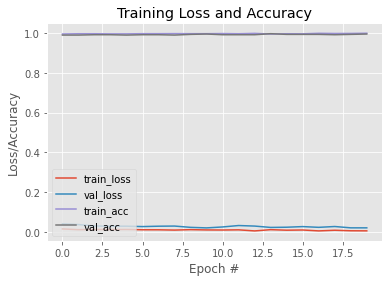

In [24]:
from tensorflow.keras.optimizers import Adam

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), 
              validation_steps=len(testX) // BS, epochs=EPOCHS)

from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=binarizer.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")